In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.signal as sp
from scipy.signal import chirp, spectrogram, butter, filtfilt, hilbert, correlate
from scipy.stats import linregress

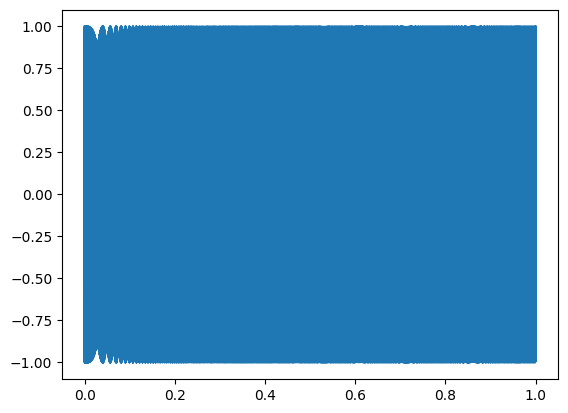

In [2]:
# Parameters
# fs = 4400e6 # ADC Sampling frequency (Hz) -- but this is sampling rate for the IF signal
# fs_chirp = 180e9
# T = 72e-6  # Chirp duration (s)
# t = np.linspace(0, T, int(fs_chirp*T))  # Time vector

# S1 = 55 # Mhz / us
# S2 = 54 # Mhz / us

# B1 = (T*1e6) * S1 * 1e6 # Hz
# B2 = (T*1e6) * S2 * 1e6 # Hz 

# f0 = 77e9


fs = 30e3           # 1 MHz sampling
T = 1           # duration
t = np.linspace(0, T, int(fs * T))

f0 = 5e3       # Start frequency
S1 = 200             # Chirp slope

phi = 2 * np.pi * (f0 * t + 0.5 * S1 * t**2)
signal = np.cos(phi)

plt.plot(t, signal)

# Generate two chirps with different slopes
# chirp1 = chirp(t, f0=f0, f1=f0 + B1, t1=T, method='linear')
# chirp2 = chirp(t, f0=f0, f1=f0 + B2, t1=T, method='linear')


# # Plot chirps
# plt.figure(figsize=(10, 6))
# plt.subplot(2, 1, 1)
# plt.plot(t, chirp1, label="Chirp 1 (Slope 1)")
# plt.title("Chirp 1")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(t, chirp2, label="Chirp 2 (Slope 2)", color='orange')
# plt.title("Chirp 2")
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.legend()

# plt.tight_layout()
# plt.show()


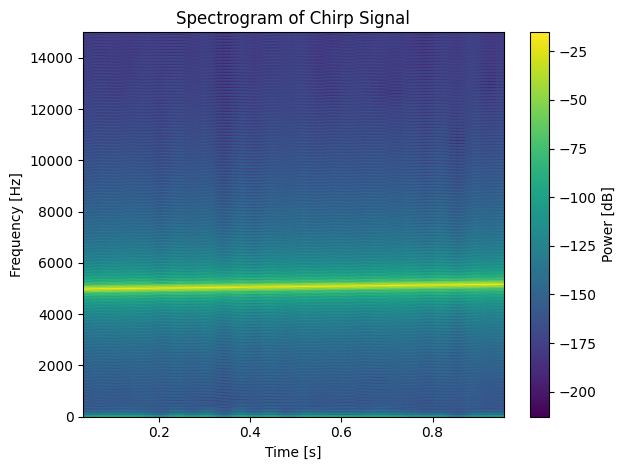

In [3]:
from scipy.signal import spectrogram

f, t_spec, Sxx = spectrogram(signal, fs=fs, nperseg=2048, noverlap=1024)
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
plt.title("Spectrogram of Chirp Signal")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
# plt.ylim([0, 75e2])
plt.colorbar(label='Power [dB]')
plt.tight_layout()
plt.show()

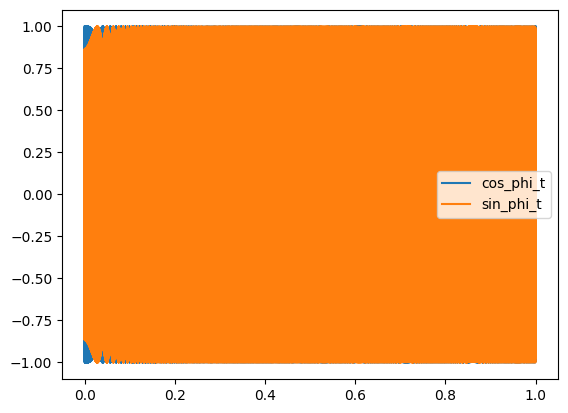

In [4]:
cos_phi_t = np.cos(phi)
sin_phi_t = np.sin(phi)

plt.plot(t, cos_phi_t, label='cos_phi_t')
plt.plot(t, sin_phi_t, label='sin_phi_t')
plt.legend()

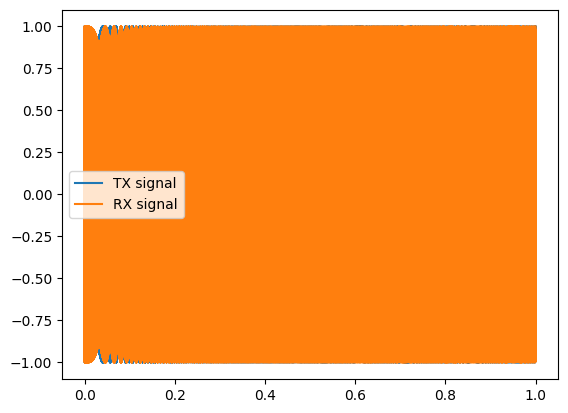

In [5]:
Srx = 150
phi_rx =  2 * np.pi * (f0 * t + 0.5 * Srx * t**2)
rx_sig = np.cos(phi_rx)

plt.plot(t, signal, label='TX signal')
plt.plot(t, rx_sig, label='RX signal')
plt.legend()

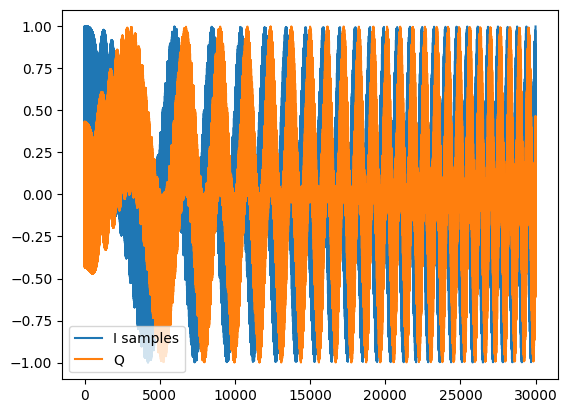

In [6]:
if_samples_i = rx_sig*cos_phi_t
if_samples_q = rx_sig*sin_phi_t

plt.plot(if_samples_i, label='I samples')
plt.plot(if_samples_q, label='Q')
plt.legend()

In [7]:
iq_if_signal = if_samples_i + 1j * if_samples_q

iq_if_signal

array([1.        +0.00000000e+00j, 0.24996924+4.32995029e-01j,
       0.25006258-4.33048478e-01j, ..., 0.31589298+4.54442729e-01j,
       0.21890152-4.18756301e-01j, 1.        +8.66806081e-14j])

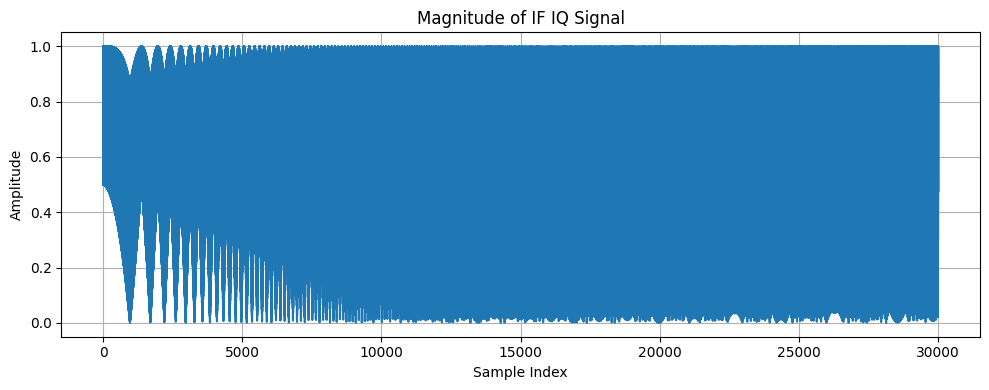

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(np.abs(iq_if_signal))
plt.title("Magnitude of IF IQ Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

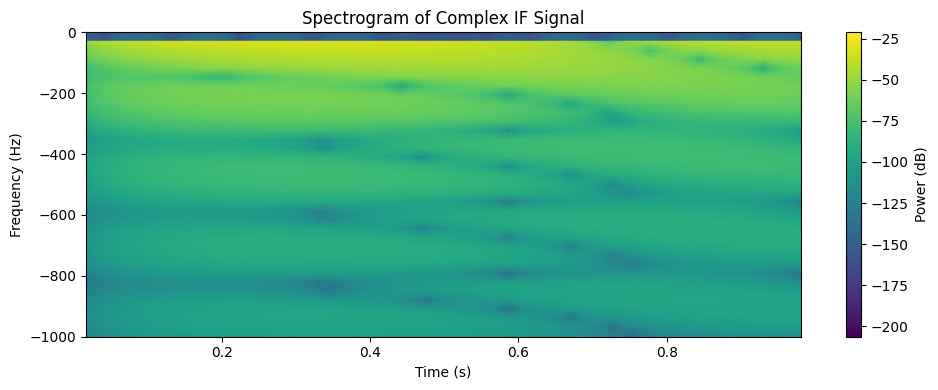

In [9]:
f, t_spec, Sxx = spectrogram(iq_if_signal, fs=fs, nperseg=1024, noverlap=768, return_onesided=False)

# Plot the spectrogram (magnitude in dB)
plt.figure(figsize=(10, 4))
plt.pcolormesh(t_spec, f, 10 * np.log10(np.abs(Sxx)), shading='gouraud')
plt.title("Spectrogram of Complex IF Signal")
plt.ylabel("Frequency (Hz)")
plt.ylim([-1e3, 0])
plt.xlabel("Time (s)")
plt.colorbar(label='Power (dB)')
plt.tight_layout()
plt.show()


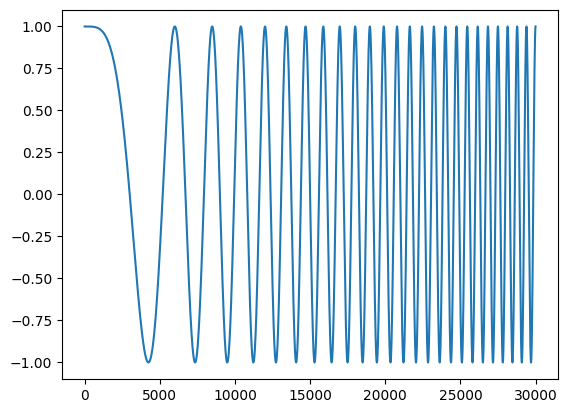

In [25]:
phi_template = np.pi*(S1-Srx)*t**2
template_sig = np.cos(phi_template) 

plt.plot(template_sig)

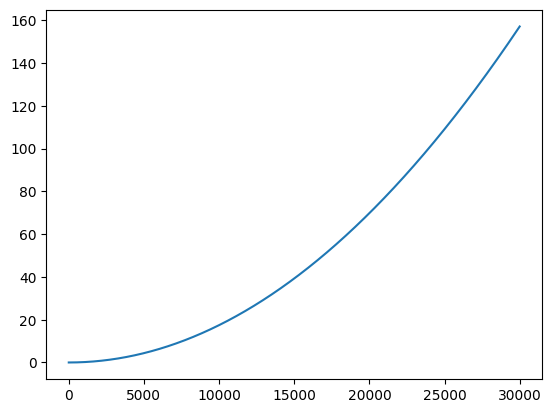

In [26]:
plt.plot(phi_template)

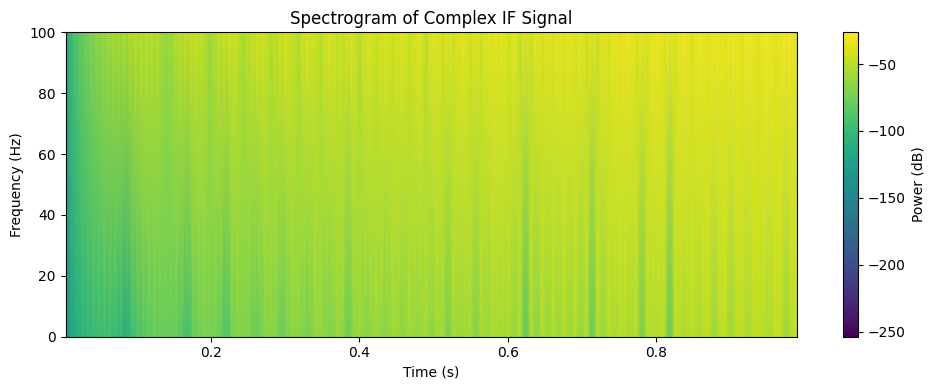

In [28]:
# Spectrogram of the template signal
f, t_spec, Sxx = spectrogram(template_sig, fs=fs)

# Plot the spectrogram (magnitude in dB)
plt.figure(figsize=(10, 4))
plt.pcolormesh(t_spec, f, 10 * np.log10(np.abs(Sxx)), shading='gouraud')
plt.title("Spectrogram of Complex IF Signal")
plt.ylabel("Frequency (Hz)")
plt.ylim([0, 100])
plt.xlabel("Time (s)")
plt.colorbar(label='Power (dB)')
plt.tight_layout()
plt.show()

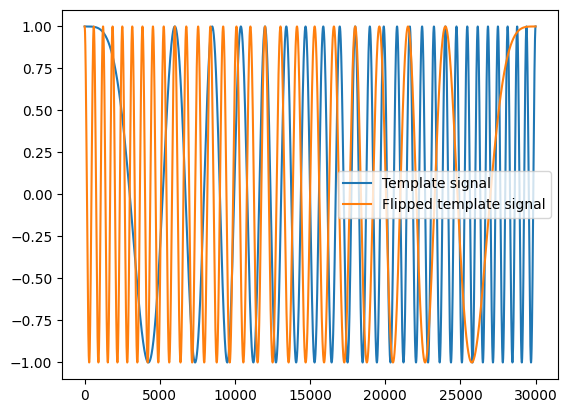

In [ ]:
# Check using lfilter 
h = template_sig[::-1]
plt.plot(template_sig, label='Template signal')
plt.plot(h, label='Flipped template signal')
plt.legend()
plt.show()


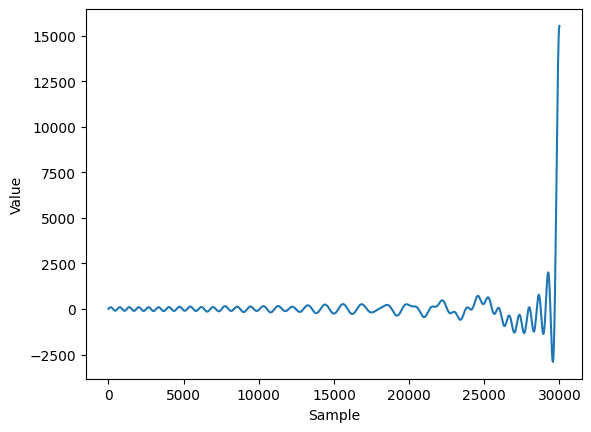

In [15]:
signoisemf = sp.lfilter(h, 1, template_sig)
plt.plot(signoisemf)
plt.xlabel("Sample")
plt.ylabel("Value")
plt.show()

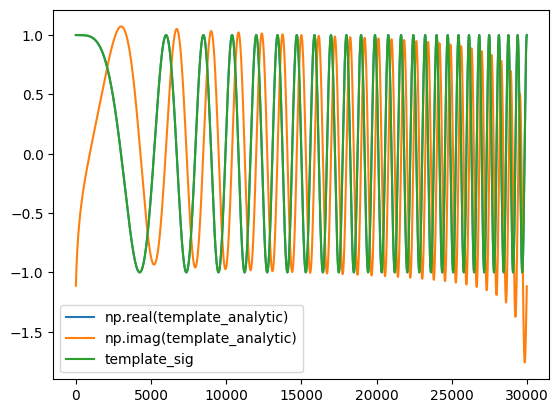

In [ ]:
template_analytic = hilbert(template_sig) # Takes the hilbert transform
plt.plot(np.real(template_analytic), label='np.real(template_analytic)')
plt.plot(np.imag(template_analytic), label='np.imag(template_analytic)')
plt.plot(template_sig, label='template_sig')
plt.legend()
plt.show()

#Real and the actual template sig are the exact same 


In [ ]:
h_mf = np.conj(template_analytic[::-1])
mf_output = sp.lfilter(h_mf, 1, iq_if_signal)

/home/sohamc1909/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sohamc1909/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


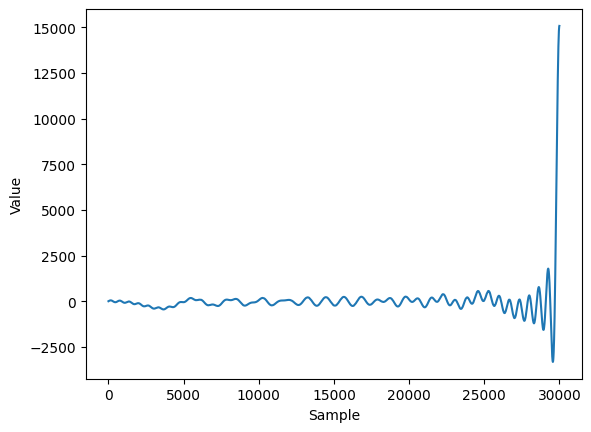

In [24]:
plt.plot(mf_output)
plt.xlabel("Sample")
plt.ylabel("Value")
plt.show()

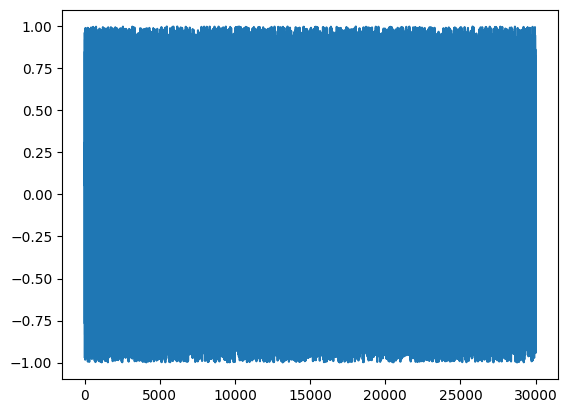

In [30]:
# Testing against random noise just to ensure correctness
random_signal = 2 * np.random.rand(30000) - 1
random_signal = hilbert(random_signal)
plt.plot(np.real(random_signal))

/home/sohamc1909/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sohamc1909/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


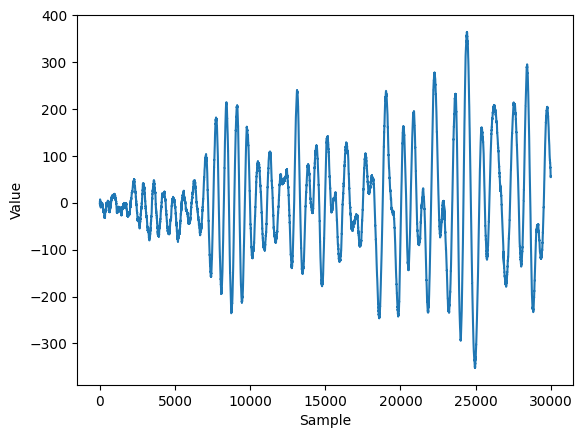

In [31]:
rand_mf_output = sp.lfilter(h_mf, 1, random_signal)
plt.plot(rand_mf_output)
plt.xlabel("Sample")
plt.ylabel("Value")
plt.show()

In [ ]:
# Can we decrease the time by resampling the iq samples 
from scipy.signal import resample

fs_target = 256
n_target = int(fs_target * T)
iq_if_signal_resampled = resample(iq_if_signal, n_target)

array([1.        +0.00000000e+00j, 0.24996924+4.32995029e-01j,
       0.25006258-4.33048478e-01j, ..., 0.31589298+4.54442729e-01j,
       0.21890152-4.18756301e-01j, 1.        +8.66806081e-14j])

In [34]:
len(iq_if_signal_resampled)

256

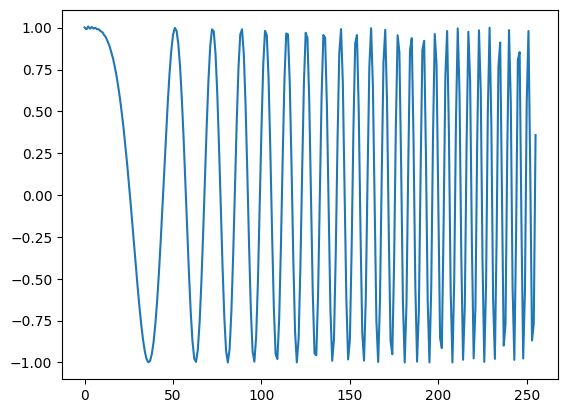

In [35]:
# Resample the tempalte_sig
template_sig_resampled = resample(template_sig, n_target)

plt.plot(template_sig_resampled)

/home/sohamc1909/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sohamc1909/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


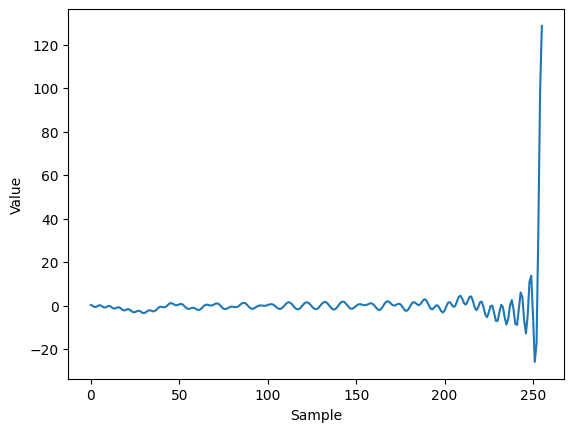

In [36]:
template_analytic_resampled = hilbert(template_sig_resampled)
h_mf = np.conj(template_analytic_resampled[::-1])
mf_output = sp.lfilter(h_mf, 1, iq_if_signal_resampled)
plt.plot(mf_output)
plt.xlabel("Sample")
plt.ylabel("Value")
plt.show()

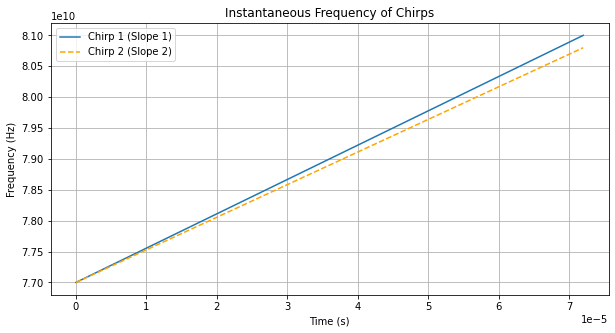

In [14]:
# Compute instantaneous frequency (slope of phase derivative)
freq1 = f0 + (B1/T) * t  # Linear chirp equation
freq2 = f0 + (B2/T) * t  # Linear chirp equation

# Plot frequency vs. time
plt.figure(figsize=(10, 5))
plt.plot(t, freq1, label="Chirp 1 (Slope 1)")
plt.plot(t, freq2, label="Chirp 2 (Slope 2)", linestyle='dashed', color='orange')
plt.title("Instantaneous Frequency of Chirps")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.legend()
plt.grid()
plt.show()

In [15]:
if_signal = chirp1*chirp2

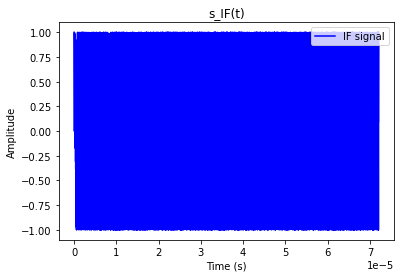

In [16]:
plt.plot(t, if_signal, label="IF signal", color='blue')
plt.title("s_IF(t)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

In [17]:
# Design a low-pass filter (LPF)
cutoff_freq = 0.25e9  # Cutoff frequency (Hz), adjust as needed
order = 4  # Filter order
nyquist = fs / 2  # Nyquist frequency

print(cutoff_freq / nyquist)

# Create Butterworth LPF
b, a = butter(order, Wn = cutoff_freq / nyquist, btype='low')

# Apply the filter
if_signal_lpf = filtfilt(b, a, if_signal)

0.11363636363636363


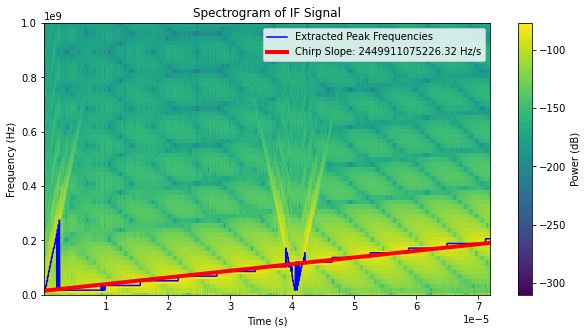

In [18]:
# Compute spectrogram (STFT)
# f, t_spec, Sxx = spectrogram(if_signal, fs) #, nperseg=256)
f, t_spec, Sxx = spectrogram(if_signal_lpf, fs)

# Convert to dB scale for better visualization
Sxx_dB = 10 * np.log10(Sxx + 1e-10)  # Avoid log(0)

# Extract peak frequency at each time step
peak_freqs = f[np.argmax(Sxx, axis=0)]

# Fit a linear regression model to estimate the chirp slope
slope, intercept, _, _, _ = linregress(t_spec, peak_freqs)

# Plot spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='auto')
plt.plot(t_spec, peak_freqs, 'b', label="Extracted Peak Frequencies")
plt.plot(t_spec, slope * t_spec + intercept, c='r', lw=4, label=f"Chirp Slope: {slope:.2f} Hz/s")
plt.colorbar(label='Power (dB)')
plt.title("Spectrogram of IF Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
# plt.ylim([0, fs/2])  # Display up to Nyquist frequency
plt.ylim([0, 1e9])
plt.legend()
plt.show() 

In [19]:
S1 = B1/T
S2 = B2/T

S1 - S2

2777777777777.7812

In [20]:
error = ((S1-S2) - slope)/(S1-S2) * 100 
error

11.803201291852702

# W/O Sync

In [51]:
tau = 0.2*T
t_wo_sync = np.linspace(0, T-tau, int(fs*(T-tau)))
B2_wo_sync = B2*(T-tau)/T

# Generate the other chirp shifted by tau
chirp2_wo_sync = chirp(t, f0=f0, f1=f0 + B2, t1=T, phi=360*(tau/T), method='linear')
# chirp2_wo_sync = np.zeros(int(fs*T))
# chirp2_wo_sync[:int(fs*tau)] = chirp(t, f0=f0, f1=f0 + B2, t1=T, method='linear')[:int(fs*tau)]
# chirp2_wo_sync[int(fs*tau):] = chirp(t_wo_sync, f0=f0, f1=f0 + B2_wo_sync, t1=T, method='linear')

No handles with labels found to put in legend.


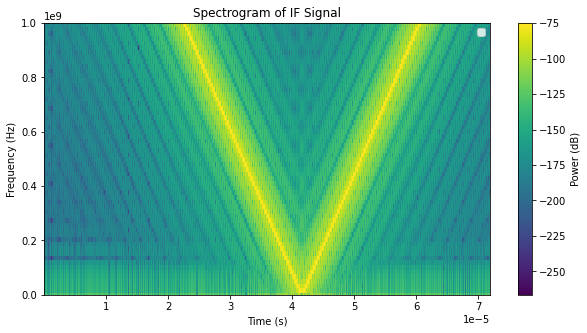

In [52]:
f1, t_spec1, Sxx1 = spectrogram(chirp2_wo_sync, fs)
# Plot spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(t_spec1, f1, 10 * np.log10(Sxx1), shading='auto')
# plt.plot(t_spec, peak_freqs, 'b', label="Extracted Peak Frequencies")
# plt.plot(t_spec, slope * t_spec + intercept, c='r', lw=4, label=f"Chirp Slope: {slope:.2f} Hz/s")
plt.colorbar(label='Power (dB)')
plt.title("Spectrogram of IF Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
# plt.ylim([0, fs/2])  # Display up to Nyquist frequency
plt.ylim([0, 1e9])
plt.legend()
plt.show() 

In [53]:
if_signal_wo_sync = chirp1 * chirp2_wo_sync

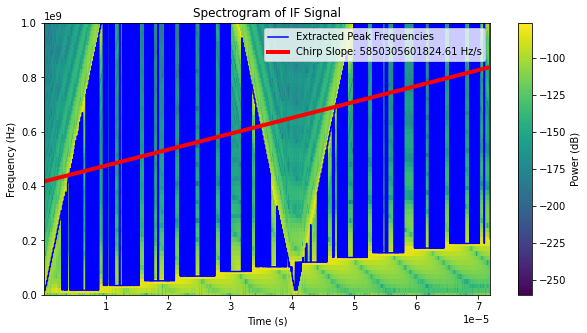

In [55]:
f2, t_spec2, Sxx2 = spectrogram(if_signal_wo_sync, fs)

# Convert to dB scale for better visualization
Sxx2_dB = 10 * np.log10(Sxx2 + 1e-10)  # Avoid log(0)

# Extract peak frequency at each time step
peak_freqs2 = f[np.argmax(Sxx2, axis=0)]

# Fit a linear regression model to estimate the chirp slope
slope2, intercept2, _, _, _ = linregress(t_spec2, peak_freqs2)

# Plot spectrogram
plt.figure(figsize=(10, 5))
plt.pcolormesh(t_spec2, f2, 10 * np.log10(Sxx2), shading='auto')
plt.plot(t_spec2, peak_freqs2, 'b', label="Extracted Peak Frequencies")
plt.plot(t_spec2, slope2 * t_spec2 + intercept2, c='r', lw=4, label=f"Chirp Slope: {slope2:.2f} Hz/s")
plt.colorbar(label='Power (dB)')
plt.title("Spectrogram of IF Signal")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
# plt.ylim([0, fs/2])  # Display up to Nyquist frequency
plt.ylim([0, 1e9])
plt.legend()
plt.show() 